In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk

/var/folders/ln/kls56lq93mq4z_459sxk1vbh0000gn/T/ipykernel_58934/3859994427.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval=interval, period=period)
[*********************100%***********************]  1 of 1 completed

Coefficient: -0.0035879103230312135
Intercept: 0.24499501269611107


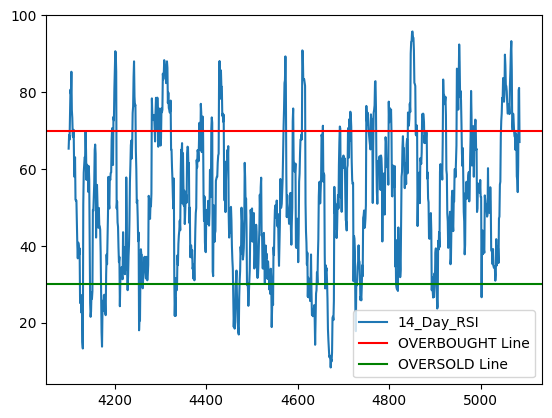

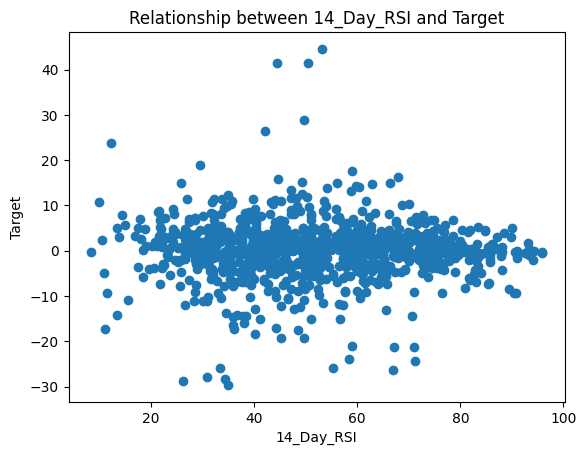

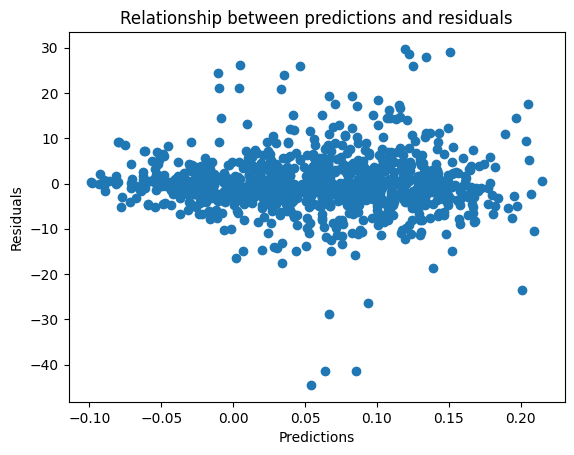

In [14]:
TICKER = "SPY"
SHIFT = 5

RSI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30
STRATEGY = f"{RSI_LENGTH}_Day_RSI"

INTERVAL = "1h"
LOOKBACK = 1000

if INTERVAL == "1h":
    PERIOD = "730d"
else:
    PERIOD = "max"


def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL, period=PERIOD):
    df = yf.download(ticker, interval=interval, period=period)
    df.columns = df.columns.get_level_values(0)
    df = df.reset_index(drop=True)

    return df.iloc[-lookback:, :]


def add_target(df, shift=SHIFT):

    df[f"Close + {shift}"] = df["Close"].shift(-shift)
    df["Target"] = df[f"Close + {shift}"] - df["Close"]
    return df


def add_rsi(df):

    price_change = df["Close"].diff()

    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    avg_gain = gain.rolling(RSI_LENGTH).mean()
    avg_loss = loss.rolling(RSI_LENGTH).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    df[f"{RSI_LENGTH}_Day_RSI"] = rsi

    plt.plot(df[f"{RSI_LENGTH}_Day_RSI"])
    plt.axhline(OVERBOUGHT, color="red")
    plt.axhline(OVERSOLD, color="green")
    plt.legend([f"{RSI_LENGTH}_Day_RSI", "OVERBOUGHT Line", "OVERSOLD Line"])

    return df.dropna()


def generate_regression_output(df, target="Target", features=f"{RSI_LENGTH}_Day_RSI"):
    subset = df[[target, features]].dropna()

    x = subset[[features]].values
    y = subset[target].values

    model = sk.linear_model.LinearRegression()
    model.fit(x, y)

    y_pred = model.predict(x)

    r2 = sk.metrics.r2_score(y, y_pred)

    coef = model.coef_[0]
    intercept = model.intercept_

    print(f"Coefficient: {model.coef_[0]}")
    print(f"Intercept: {model.intercept_}")

    plt.figure()
    plt.scatter(x, y)
    plt.title(f"Relationship between {features} and {target}")
    plt.xlabel(features)
    plt.ylabel(target)
    return coef, intercept

def test_linearity(df, coef, intercept):

    df["Prediction"] = (coef * df[STRATEGY]) + intercept
    df["Residuals"] = df["Prediction"] - df["Target"]

    plt.figure()
    plt.scatter(df["Prediction"], df["Residuals"])
    plt.title("Relationship between predictions and residuals")
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")
    return df

def main():
    df = get_data()
    df = add_target(df)
    df = add_rsi(df)
    fit_coef, fit_intercept = generate_regression_output(df)
    df = test_linearity(df, fit_coef, fit_intercept)
    return df


df = main()